In [17]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import periodogram
from scipy.linalg import cholesky
import ipywidgets as widgets  # interactive display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [18]:
# Plotting Functions

def plot_s_fr(t, stimulus, firing_rate):
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].plot(t, stimulus, 'k')
  ax[0].set_ylabel('Stimulus Orientation (deg)')
  ax[0].set_ylim([-60, 60])
  ax[0].set_yticks(np.arange(-60,61,20))
  ax[0].set_xlim([0, 500])
  ax[1].set_ylabel("Average Firing Rate (Hz)")
  ax[1].plot(t,firing_rate, 'k')
  ax[1].set_ylim([0, 60])
  ax[1].set_yticks(np.arange(0, 61,20))
  ax[1].set_xlabel("Time (ms)")
  ax[1].set_xlim([0, 500])
  plt.show()

def plot_spikes(T, spike_trains, n_trains):
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))
  for i in range(n_trains):
    plt.eventplot(np.argwhere(spike_trains[i]).T,lineoffsets=i, linelengths=0.5, colors=[0,0,0])
  plt.xlabel("Time (ms)")
  plt.xlim([0,T])
  plt.ylabel("Spikes")
  plt.yticks(np.arange(0, n_trains, 1))
  plt.show()

def plot_empirical_fr(t, spike_trains):
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))
  plt.plot(t,np.mean(spike_trains,axis=0)*1000, 'k')
  plt.ylabel("Empirical Firing Rate (Hz)")
  plt.ylim([0, 60])
  plt.yticks(np.arange(0, 61,20))
  plt.xlabel("Time (ms)")
  plt.xlim([0, 500])
  plt.show()

def plot_ISI_Fano(ISI, mean_sc, var_sc):
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].hist(ISI, bins=20, color='gray', edgecolor='black', density=True)
  ax[0].set_ylabel('ISI density')
  ax[0].set_xlabel("Interspike Interval (ms)")
  ax[1].scatter(mean_sc,var_sc,color='k')
  ax[1].set_ylabel("Variance Spikes")
  ax[1].set_xlabel("Mean Spikes")
  ax[1].axline([0, 0], [1, 1], color='r')
  plt.show()

def plot_autocorr(time, auto_corr):
  plt.plot(time, auto_corr,color='k')
  plt.xlim([-100, 100])
  plt.xlabel("Time (ms)")
  plt.ylabel("Auto-correlation")

def plot_psd(f, psd):
  plt.plot(f, psd,color='k')
  plt.xlim([0, np.max(f)/2])
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Power Density")

def plot_spike_triggered_average(t, stim, color):
  plt.plot(t, stim, color=color)
  plt.xlabel("Time (ms)")
  plt.ylabel("Velocity")
  plt.xlim([-300, 0])

def plot_CV_refractory(tau, CV):
  plt.plot(tau, CV, color='k')
  plt.xlabel("Refractory Constant (ms)")
  plt.ylabel("Coefficient of Variation")
  plt.ylim([0.5, 1.0])

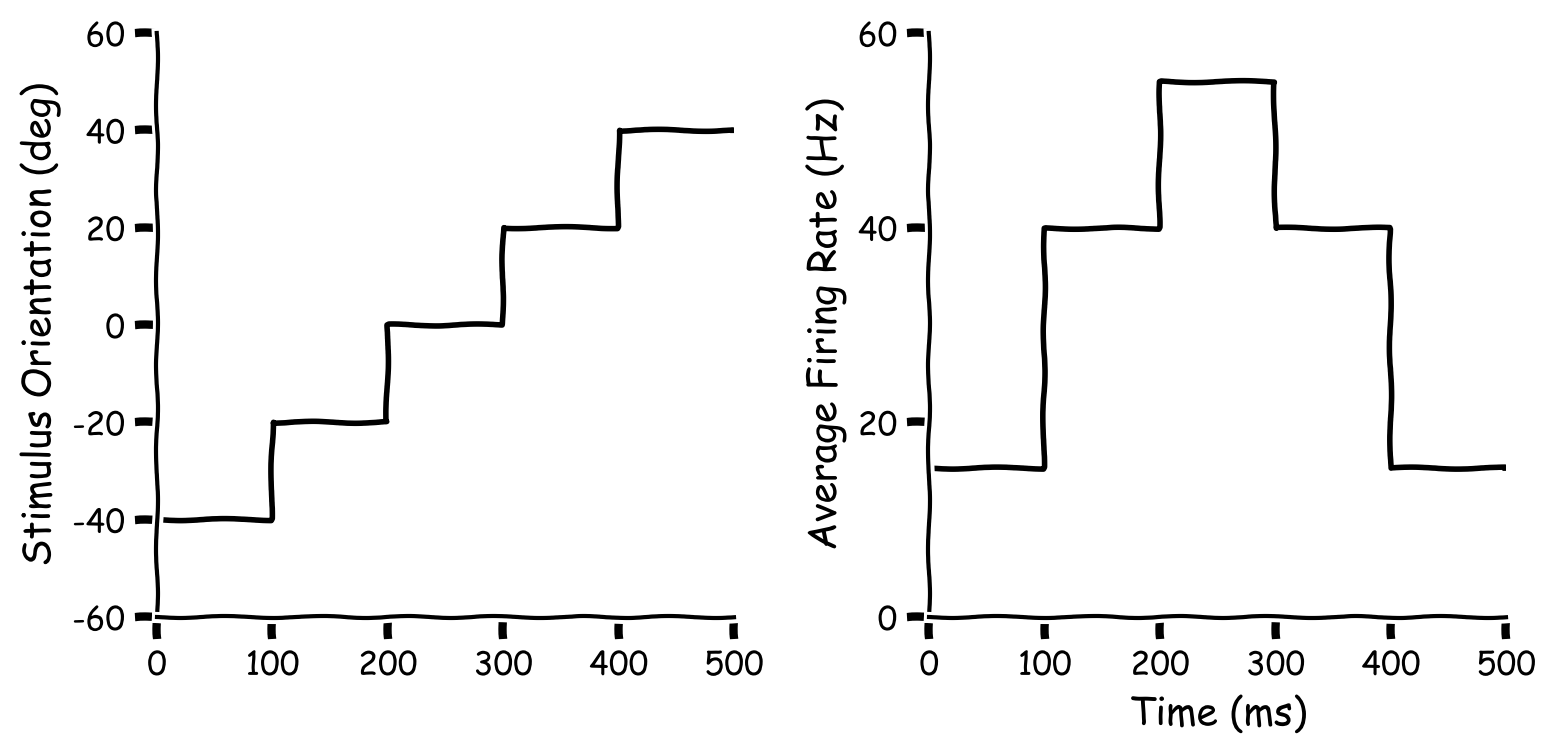

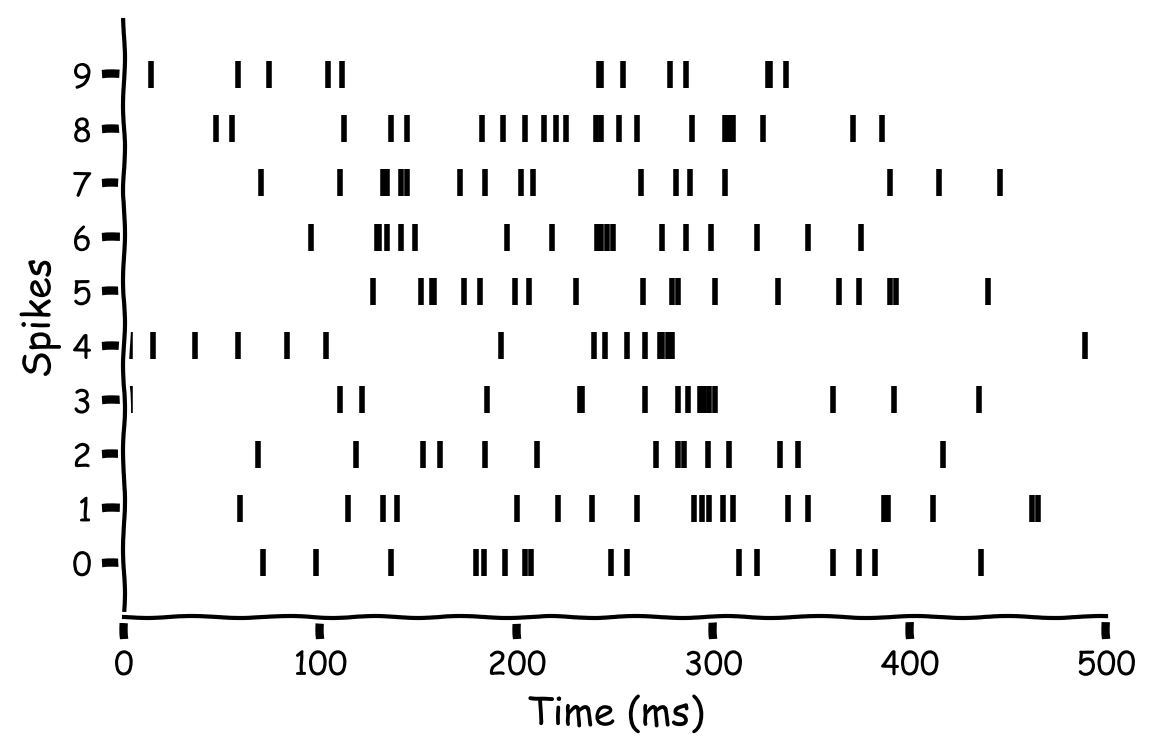

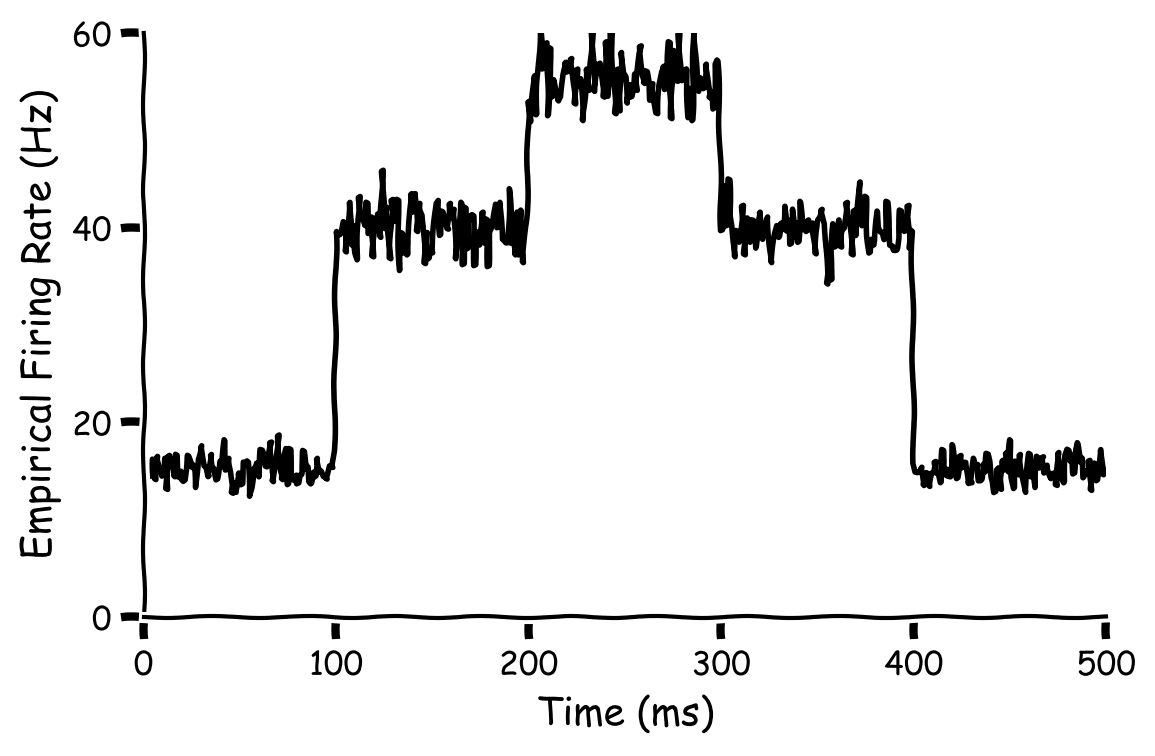

In [19]:
# Record Settings
dt = 1  # 1ms
T = 500 # 500ms
t = np.arange(0, T, dt)
rmax=55
smax=0
sigmaf=25
tuning_function=lambda s: rmax*np.exp(-0.5*(s-smax)**2/sigmaf**2)
stimulus=np.array([-40, -20, 0, 20, 40]).repeat(len(t)//5)
fr = tuning_function(stimulus)
with plt.xkcd():
    plot_s_fr(t,stimulus, fr)
n_trains = 10000
p_spike = fr*dt/1000
spike_trains = (rng.random(size=(n_trains, len(t))) < p_spike).astype(np.uint8)
with plt.xkcd():
    plot_spikes(T,spike_trains, n_trains=10)
    plot_empirical_fr(t, spike_trains)

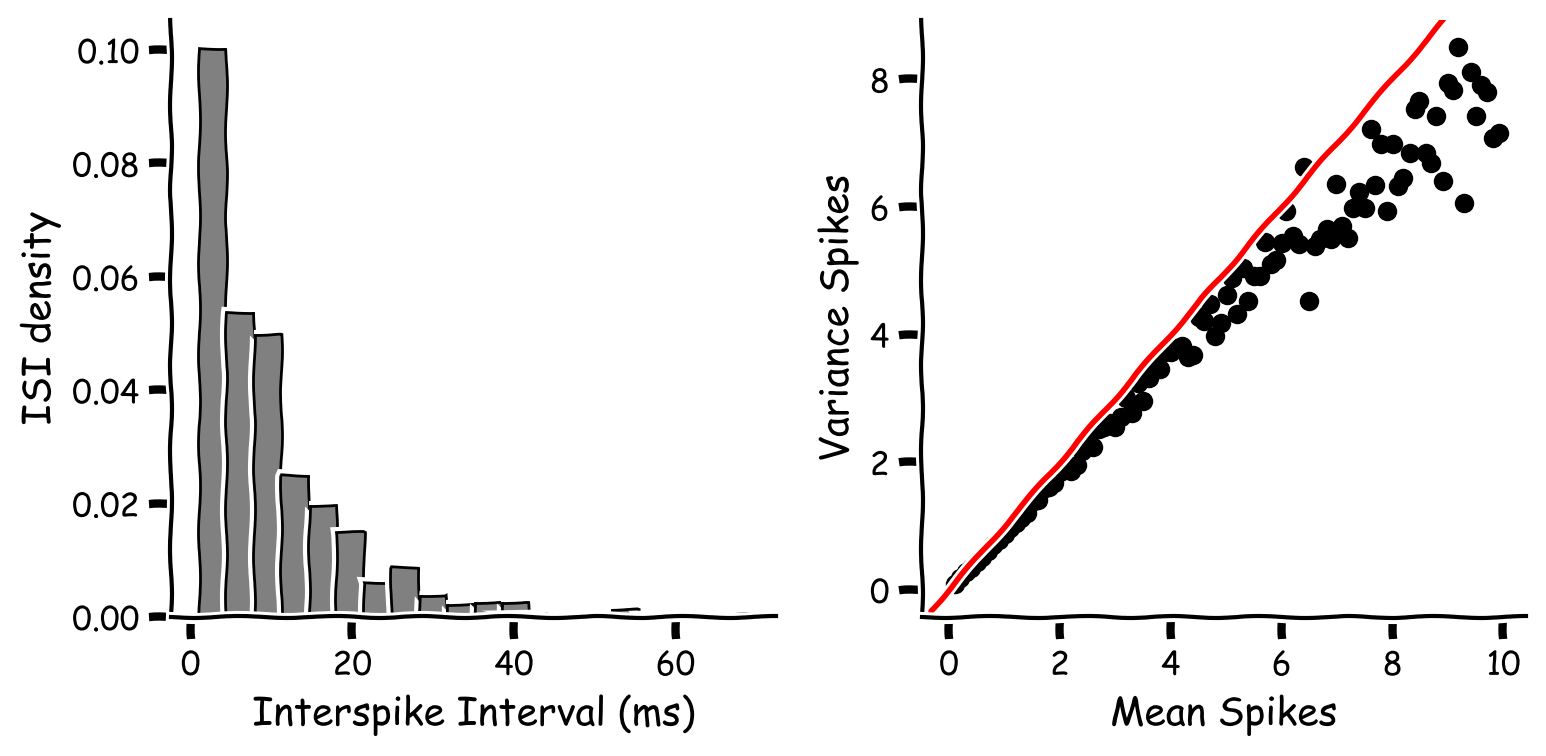

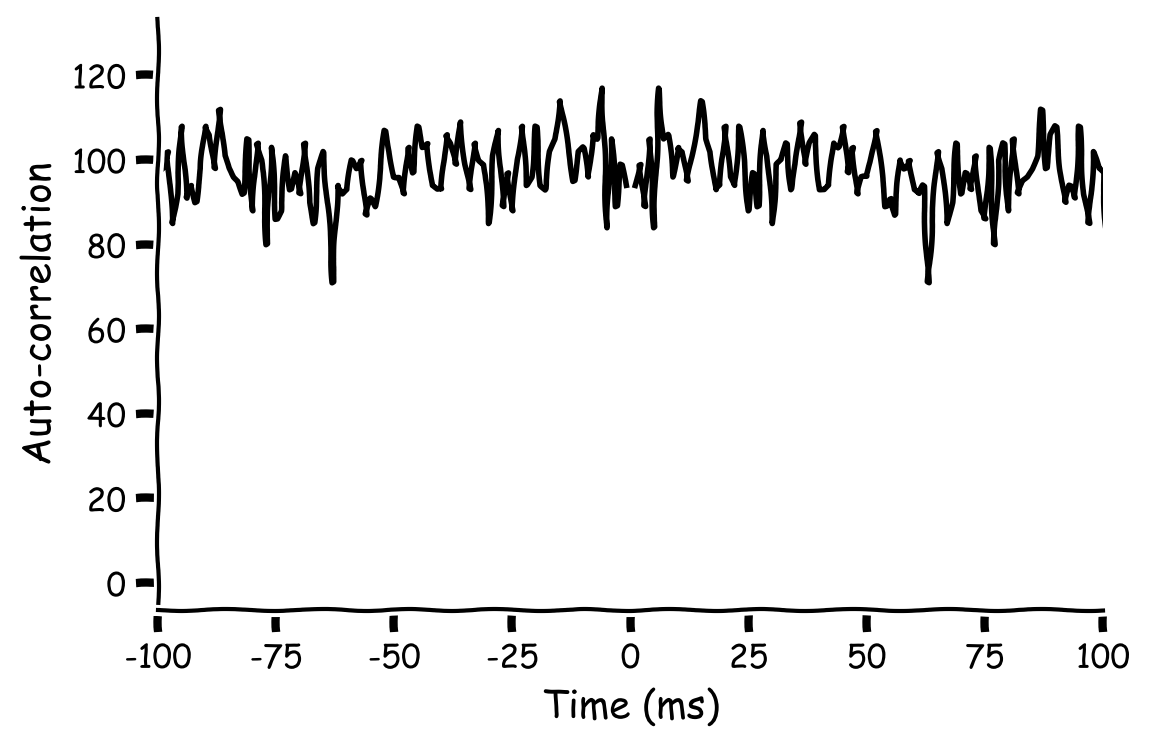

In [20]:
# Check the metrics within one spike train

dt = 1  
T = 10000
t = np.arange(0, T, dt)
fr = 100
p_spike = fr*dt/1000
spike_train = (rng.random(size=len(t)) < p_spike).astype(np.uint8)
spike_event = np.argwhere(spike_train).squeeze()
ISI = np.diff(spike_event)*dt
interval = 100
mean_sc, var_sc = [], []
for bin_size in np.arange(1,interval,1):
    spike_count = spike_train[:len(t)//bin_size*bin_size].reshape(-1,bin_size).sum(axis=1)
    mean_sc.append(np.mean(spike_count,axis=0))
    var_sc.append(np.var(spike_count,axis=0))
with plt.xkcd():
    plot_ISI_Fano(ISI,mean_sc,var_sc)

time = np.arange(-T+dt,T,dt)
Qss = np.correlate(spike_train, spike_train, mode='full').astype(np.float64)
Qss[len(t)-1] = np.nan
with plt.xkcd():
    plot_autocorr(time, Qss)

In [21]:
# Add refractory period
@widgets.interact(tau = widgets.IntSlider(value=10, min=1, max=100, step=1))
def play_with_refractory(tau):
    dt = 1  
    T = 10000
    t = np.arange(0, T, dt)
    fr = 100
    p0 = fr*dt/1000
    spike_train = np.full(len(t),np.nan)
    p = p0
    for i in range(len(t)):
        deltap = (p0-p)/tau*dt
        p += deltap
        spike = rng.random() < p
        spike_train[i] = int(spike)
        if spike:
            p = 0

    spike_event = np.argwhere(spike_train).squeeze()
    ISI = np.diff(spike_event)*dt

    interval = 100
    mean_sc, var_sc = [], []
    for bin_size in np.arange(1,interval,1):
        spike_count = spike_train[:len(t)//bin_size*bin_size].reshape(-1,bin_size).sum(axis=1)
        mean_sc.append(np.mean(spike_count,axis=0))
        var_sc.append(np.var(spike_count,axis=0))
    with plt.xkcd():
        plot_ISI_Fano(ISI,mean_sc,var_sc)

    time = np.arange(-T+dt,T,dt)
    Qss = np.correlate(spike_train, spike_train,mode='full').astype(np.float64)
    Qss[len(t)-1] = np.nan
    with plt.xkcd():
        plot_autocorr(time, Qss)

interactive(children=(IntSlider(value=10, description='tau', min=1), Output()), _dom_classes=('widget-interact…

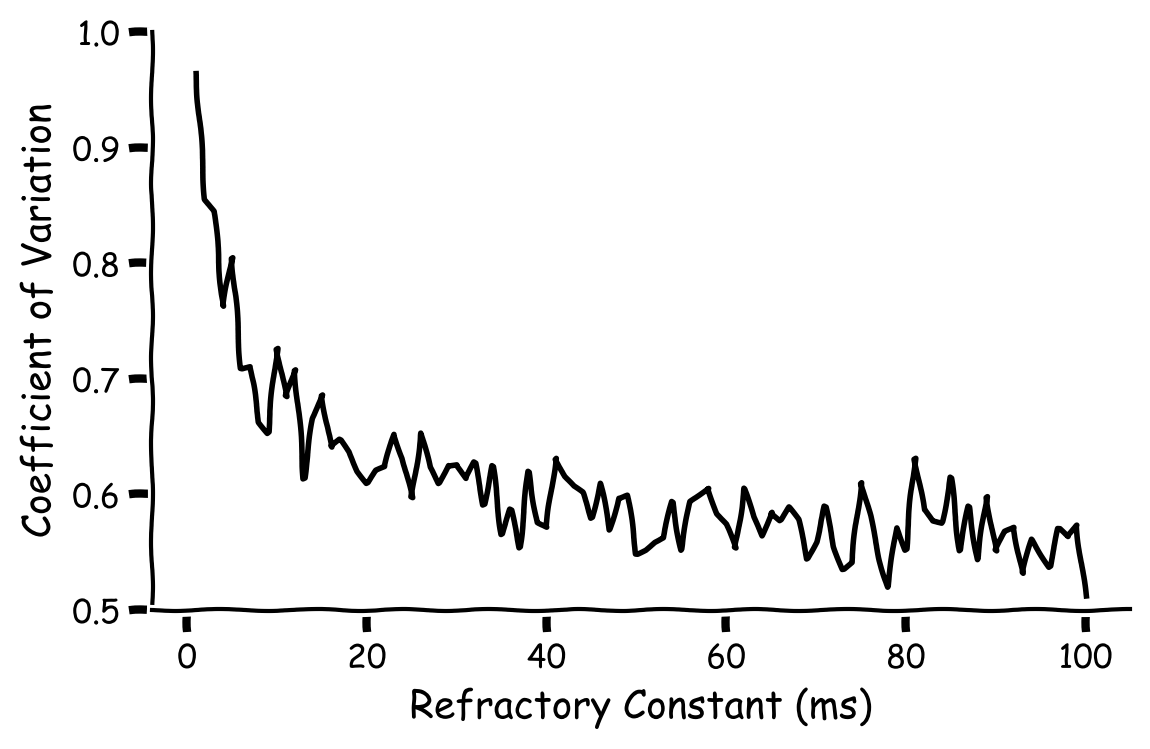

In [22]:
# Try different refractory periods
def CV_cal(tau):
    dt = 1  
    T = 10000
    t = np.arange(0, T, dt)
    fr = 100
    p0 = fr*dt/1000
    spike_train = np.full(len(t),np.nan)
    p = p0
    for i in range(len(t)):
        deltap = (p0-p)/tau*dt
        p += deltap
        spike = rng.random() < p
        spike_train[i] = int(spike)
        if spike:
            p = 0

    spike_event = np.argwhere(spike_train).squeeze()
    ISI = np.diff(spike_event)*dt
    CV = np.std(ISI, ddof=1)/np.mean(ISI)
    return CV

CV = []
tau_list = np.arange(1, 101, 1)
for tau in tau_list:
    CV.append(CV_cal(tau))
CV = np.array(CV)
with plt.xkcd():
    plot_CV_refractory(tau_list, CV)


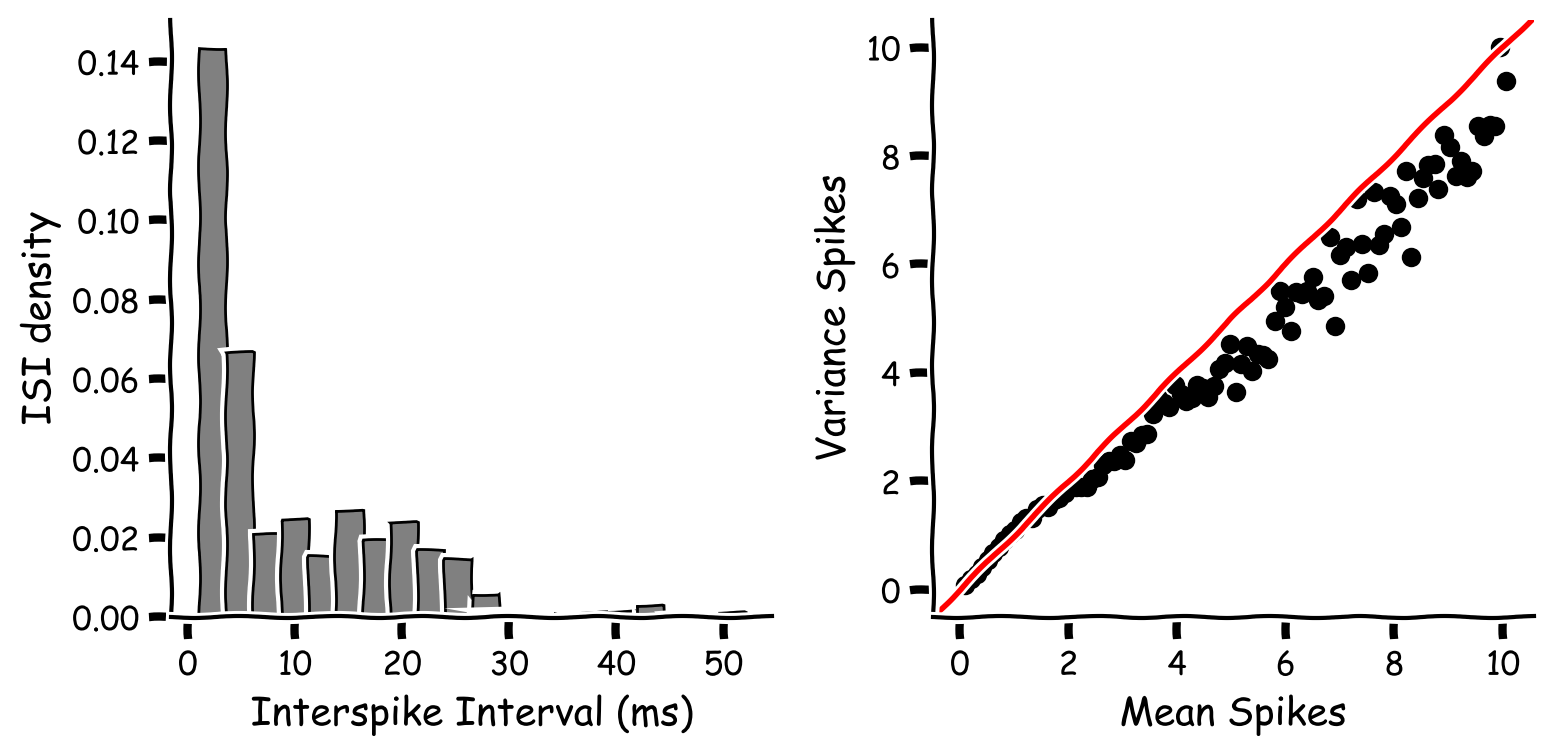

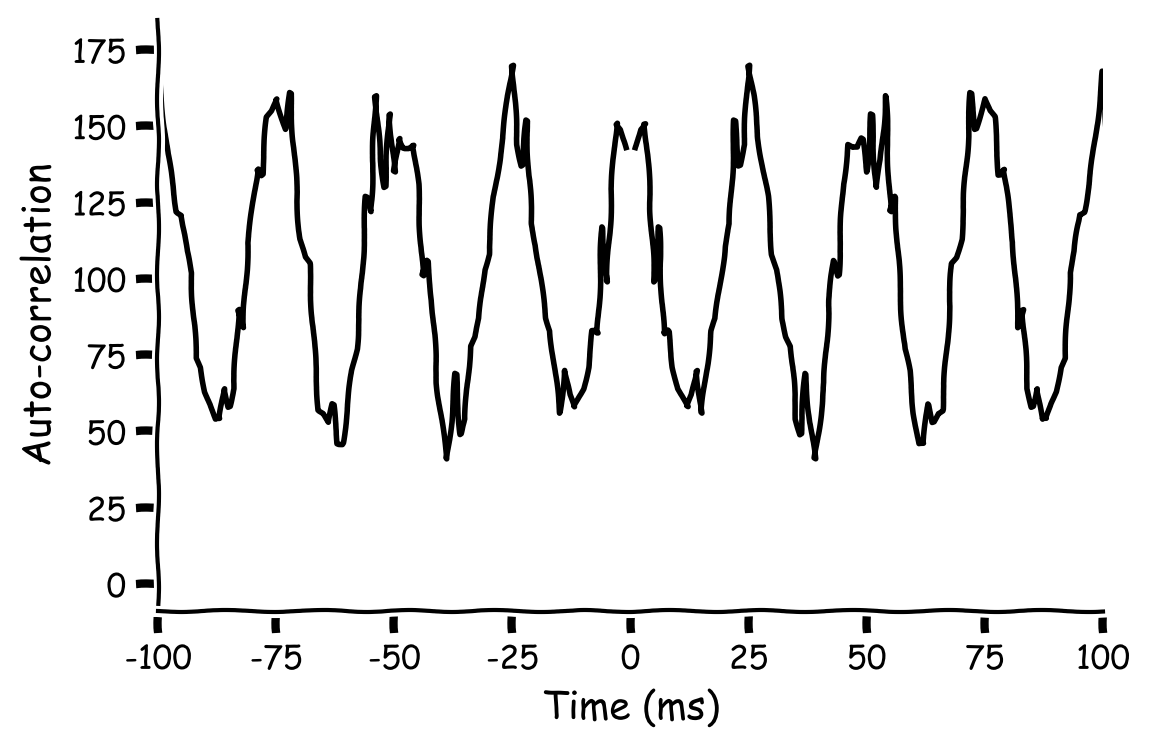

In [23]:
# Add oscillation
dt = 1  
T = 10000
t = np.arange(0, T, dt)
fr = 100*(1+np.cos(2*np.pi*t/25))
p_spike = fr*dt/1000
spike_train = (rng.random(size=len(t)) < p_spike).astype(np.uint8)
spike_event = np.argwhere(spike_train).squeeze()
ISI = np.diff(spike_event)*dt

interval = 100
mean_sc, var_sc = [], []
for bin_size in np.arange(1,interval,1):
    spike_count = spike_train[:len(t)//bin_size*bin_size].reshape(-1,bin_size).sum(axis=1)
    mean_sc.append(np.mean(spike_count,axis=0))
    var_sc.append(np.var(spike_count,axis=0))
with plt.xkcd():
    plot_ISI_Fano(ISI,mean_sc,var_sc)

time = np.arange(-T+dt,T,dt)
Qss = np.correlate(spike_train, spike_train, mode='full').astype(np.float64)
Qss[len(t)-1] = np.nan
with plt.xkcd():
    plot_autocorr(time, Qss)

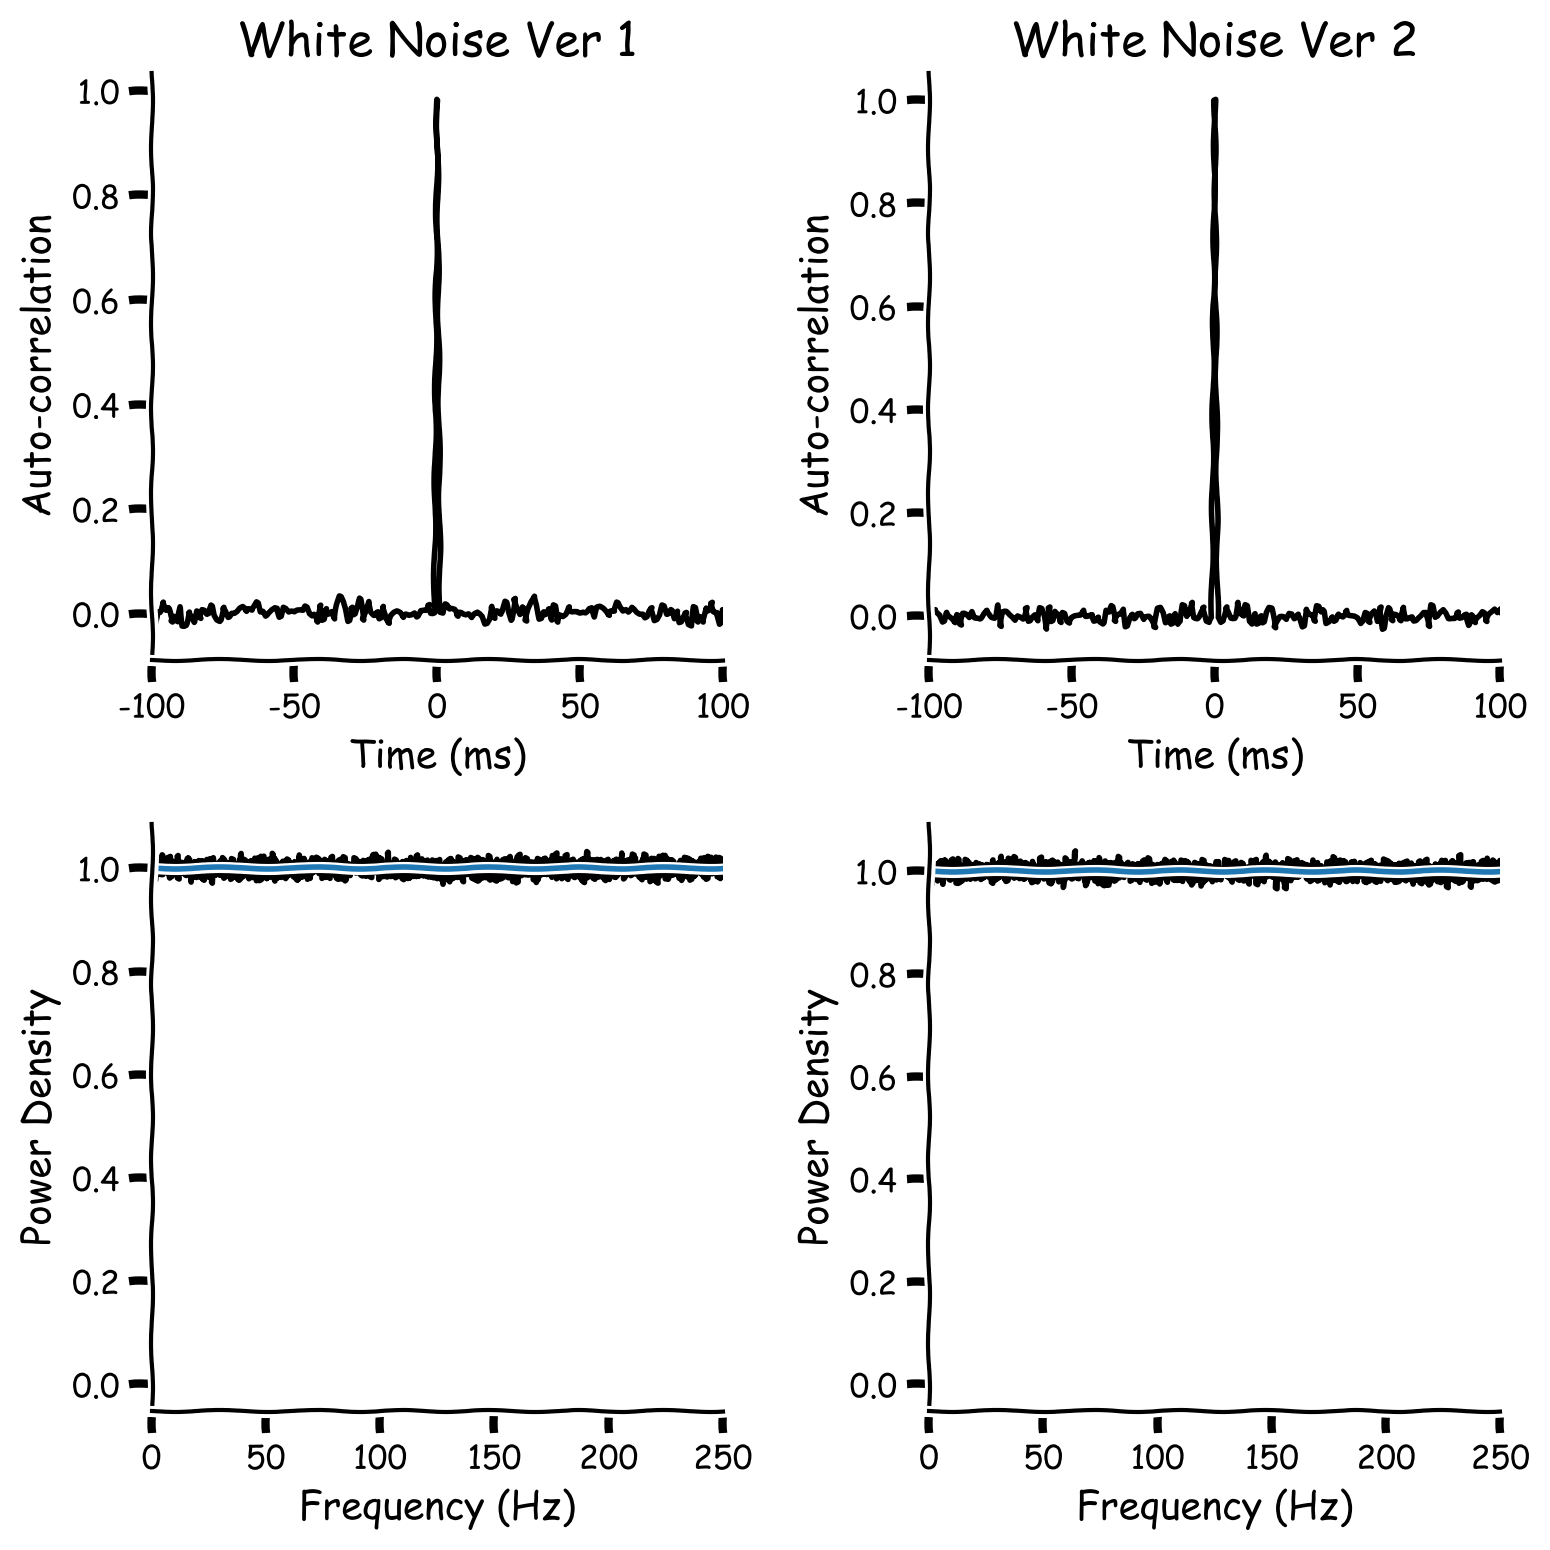

In [24]:
# Generate white noise
dt = 1
T = 10000
t = np.arange(0, T, dt)
sigma = 1
n_samples = 10000
mu = np.zeros(len(t))
cxx = np.identity(len(t))*sigma**2/dt
R = cholesky(cxx)
white_noise_1 = rng.standard_normal((n_samples, len(t))) @ R
time = np.arange(-T+dt,T,dt)
auto_corr_1 = np.correlate(white_noise_1[0], white_noise_1[0], mode='full')
white_noise_2 = rng.normal(loc=0,scale=sigma/np.sqrt(dt),size=(n_samples, len(t)))
auto_corr_2 = np.correlate(white_noise_2[0], white_noise_2[0], mode='full')
f, psd_1 = periodogram(white_noise_1, fs=1/dt*1000)
f, psd_2 = periodogram(white_noise_2, fs=1/dt*1000)

with plt.xkcd():
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    plt.sca(ax[0,0])
    plot_autocorr(time, auto_corr_1/len(t)*dt)
    plt.title("White Noise Ver 1")
    plt.sca(ax[0,1])
    plot_autocorr(time, auto_corr_2/len(t)*dt)
    plt.title("White Noise Ver 2")
    plt.sca(ax[1,0])
    plot_psd(f, np.mean(psd_1,axis=0)/2*1000)
    plt.axhline(sigma**2)
    plt.sca(ax[1,1])
    plot_psd(f, np.mean(psd_2,axis=0)/2*1000)
    plt.axhline(sigma**2)
    plt.show

In [25]:
# dt = 1
# T = 10000
# t = np.arange(0, T, dt)
# r0 = 2
# tau = 20
# width = 200
# white_noise = rng.normal(loc=0,scale=1/np.sqrt(dt),size=len(t))
# r = np.full(t.shape, np.nan)
# r[0] = r0
# for i in range(len(t)-1):
#     deltar = dt/tau*(np.max(r0+white_noise[i],0)-r[i])
#     r[i+1] = r[i] + deltar
# Qrs = cyclic_corr(r, white_noise)/white_noise.size
# # Qrs = np.flipud(np.correlate(white_noise, r, mode='full')[:,None])
# p_spike = r*dt/1000
# n_trains = 1000
# white_noise = np.concatenate((np.zeros(width),white_noise),axis=0)
# spike_triggered_average = []
# for i_train in range(n_trains):
#     spike_train = (rng.random(size=(len(t))) < p_spike).astype(np.uint8)
#     spike_event = np.argwhere(spike_train).squeeze()
#     spike_event = spike_event[spike_event>width]
#     temp = []
#     for i in spike_event:
#         temp.append(white_noise[i-width:i])
#     spike_triggered_average.append(np.array(temp).mean(axis=0))
# spike_triggered_average = np.array(spike_triggered_average).mean(axis=0)
# # plt.plot(spike_triggered_average);plt.show()
# plt.plot(Qrs);plt.show()


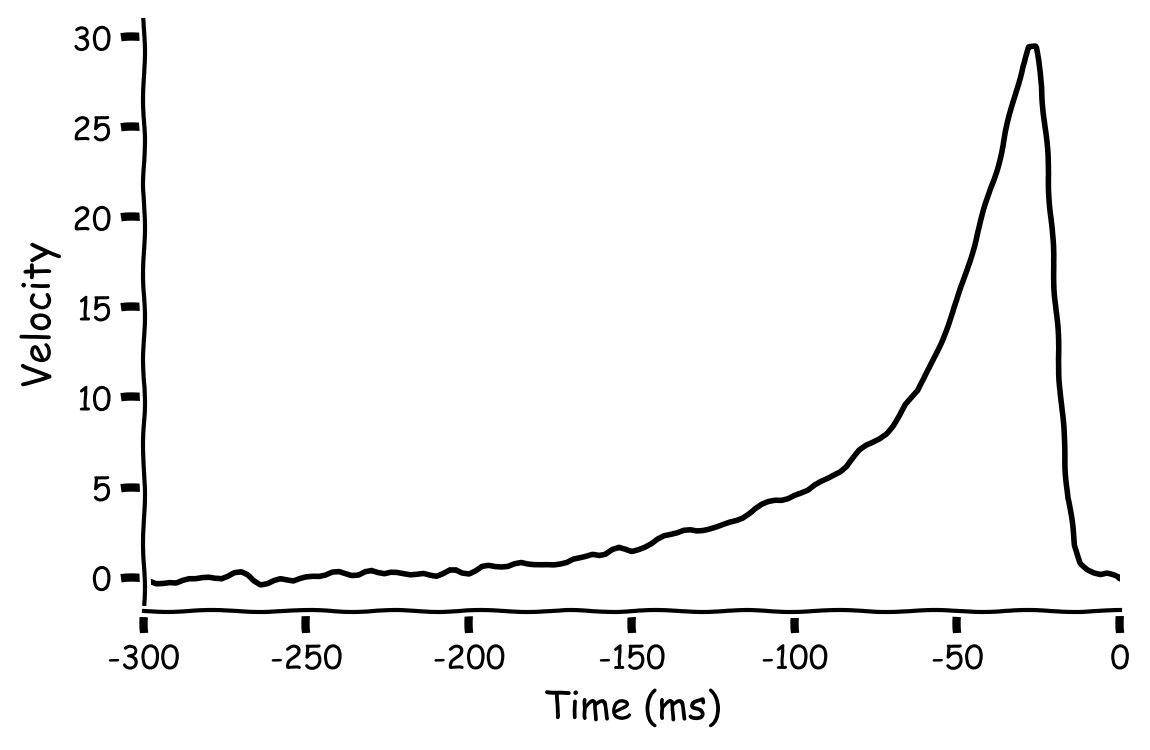

In [26]:
c1p8 = loadmat("c1p8.mat")
rho = c1p8['rho']
stim = c1p8['stim']

width = 150
dt = 2
t = np.linspace(dt, dt*width, width)
spike_event = np.argwhere(rho).squeeze()
spike_event = spike_event[spike_event>width]
temp = []
for i in spike_event:
    temp.append(stim[i-width:i])
spike_triggered_average = np.array(temp).mean(axis=0)

with plt.xkcd():
    plot_spike_triggered_average(t-np.max(t), spike_triggered_average, color='k')

In [27]:
@widgets.interact(interval = widgets.IntSlider(value=10, min=0, max=100, step=2))
def play_with_interval(interval):
    template = np.concatenate((np.ones(1),np.zeros(interval//2),np.ones(1)),axis=0)
    added_spikes_triggered_average = np.convolve(spike_triggered_average.squeeze(), template, mode='valid')

    two_spikes = np.convolve(rho.squeeze(), template, mode='valid')
    two_spikes_event = np.argwhere(two_spikes==2).squeeze()
    two_spikes_event = two_spikes_event[two_spikes_event>width]
    temp = []
    for i in two_spikes_event:
        temp.append(stim[i-width:i])
    two_spikes_triggered_average = np.array(temp).mean(axis=0)

    idx = np.diff(spike_event) == interval//2 + 1
    two_adj_spikes_event = spike_event[:-1][idx]
    temp = []
    for i in two_adj_spikes_event:
        temp.append(stim[i-width:i])
    two_adj_spikes_triggered_average = np.array(temp).mean(axis=0)

    with plt.xkcd():
        t = np.linspace(dt, dt*width, width)
        plot_spike_triggered_average(t-np.max(t), two_spikes_triggered_average, color='blue')
        plot_spike_triggered_average(t-np.max(t), two_adj_spikes_triggered_average, color='r')
        t = np.linspace(dt, dt*(width - interval//2 - 1), (width - interval//2 - 1))
        plot_spike_triggered_average(t-np.max(t), added_spikes_triggered_average, color='k')


interactive(children=(IntSlider(value=10, description='interval', step=2), Output()), _dom_classes=('widget-in…